In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wwtp=pd.read_csv('Data/wwtp_input_data_uganda_new.csv')

In [3]:
def explore_dataframe(df, name="DataFrame"): #user defined function to get the shape,info and description of the dataset
    print(f"\n===== {name} Overview =====")
    
    print("\nShape:")
    print(df.shape)
    
    print("\nInfo:")
    print("-" * 40)
    df.info()
    
    print("\nDescription:")
    print("-" * 40)
    print(df.describe(include='all'))

In [4]:
explore_dataframe(wwtp,name='Wastewater')


===== Wastewater Overview =====

Shape:
(25, 8)

Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Lon                     25 non-null     float64
 1   Lat                     25 non-null     float64
 2   Subregion               25 non-null     object 
 3   treatment_type          25 non-null     object 
 4   treatment_fraction      0 non-null      float64
 5   Capacity                25 non-null     float64
 6   removalfraction_sewer   0 non-null      float64
 7   removalfraction_onsite  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 1.7+ KB

Description:
----------------------------------------
              Lon        Lat Subregion treatment_type  treatment_fraction  \
count   25.000000  25.000000        25             25                 0.0   
unique    

In [5]:
wwtp.head()



,Lon,Lat,Subregion,treatment_type,treatment_fraction,Capacity,removalfraction_sewer,removalfraction_onsite
0,33.488340,0.614819,Buikwe,primary,NaN,800.0000,NaN,NaN
1,33.470204,0.615676,Buvuma,secondary,NaN,400.0000,NaN,NaN
2,31.346599,1.440845,Jinja,not treated,NaN,0.7923,NaN,NaN
3,33.219319,0.424790,Jinja,tertiary,NaN,12000.0000,NaN,NaN
4,30.002699,-1.257092,Buikwe,pond,NaN,1300.0000,NaN,NaN


In [6]:
# Check how many non-null values are in the target candidate columns
wwtp[['removalfraction_sewer', 'removalfraction_onsite']].notnull().sum()


removalfraction_sewer     0
removalfraction_onsite    0
dtype: int64

In [7]:
df_cluster = wwtp[['treatment_type', 'Subregion', 'Capacity']].dropna()
df_cluster.shape


(25, 3)

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define categorical and numeric columns
categorical_features = ['treatment_type', 'Subregion']
numeric_features = ['Capacity']

# Create the transformers
categorical_transformer = OneHotEncoder(drop='first', sparse=False)
numeric_transformer = StandardScaler()

# Combine into one ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Fit the full preprocessor (with both encoder and scaler)
X_scaled = preprocessor.fit_transform(df_cluster)

# Now access the fitted OneHotEncoder from the preprocessor
fitted_encoder = preprocessor.named_transformers_['cat']
encoded_cols = fitted_encoder.get_feature_names_out(categorical_features)

# Combine with numeric feature(s)
all_feature_names = list(encoded_cols) + numeric_features

# Convert to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=all_feature_names)
df_scaled.head()



c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,treatment_type_pond,treatment_type_primary,treatment_type_secondary,treatment_type_tertiary,Subregion_Buvuma,Subregion_Jinja,Subregion_Mayuge,Capacity
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.208158
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.267277
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.326279
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.447181
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.134259


In [9]:
from sklearn.cluster import KMeans

# Fit KMeans on the scaled data
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Preview
df_cluster.head()


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,treatment_type,Subregion,Capacity,cluster
0,primary,Buikwe,800.0000,0
1,secondary,Buvuma,400.0000,0
2,not treated,Jinja,0.7923,1
3,tertiary,Jinja,12000.0000,1
4,pond,Buikwe,1300.0000,0


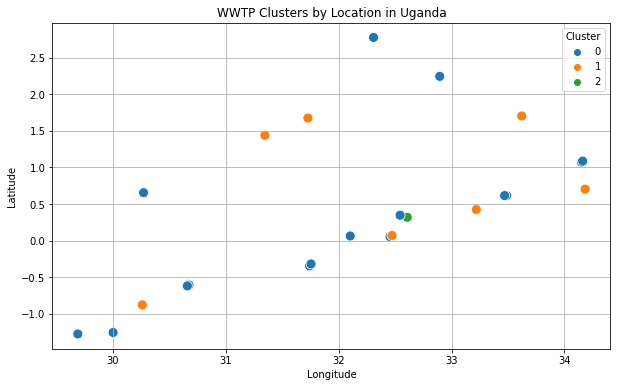

In [10]:
df_cluster = df_cluster.merge(wwtp[['Lat', 'Lon']], left_index=True, right_index=True)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='Lon', y='Lat', hue='cluster', palette='tab10', s=100)
plt.title('WWTP Clusters by Location in Uganda')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [11]:
# Append cluster labels to original data
wwtp_clustered = wwtp.copy()
wwtp_clustered['cluster'] = df_cluster['cluster']

# Summary statistics by cluster
profile = wwtp_clustered.groupby('cluster').agg({
    'Capacity': ['mean', 'min', 'max', 'std'],
    'treatment_type': lambda x: x.mode().iloc[0],  # Most common
    'Subregion': lambda x: x.mode().iloc[0],
    'Lat': 'mean',
    'Lon': 'mean'
})

profile


Capacity                                   treatment_type  \
                 mean         min      max          std       <lambda>   
cluster                                                                  
0          553.823529      1.0000   5400.0  1312.232984           pond   
1         1827.827471      0.7923  12000.0  4495.134996       tertiary   
2        33000.000000  33000.0000  33000.0          NaN    not treated   

        Subregion       Lat        Lon  
         <lambda>      mean       mean  
cluster                                 
0          Buikwe  0.265054  31.943840  
1           Jinja  0.734323  32.404717  
2           Jinja  0.318488  32.607589

In [12]:
import pandas as pd
import plotly.express as px
import numpy as np

# Ensure a copy of the clustered DataFrame
wwtp = df_cluster.copy()

# Ensure small capacity plants are visible
wwtp["AdjustedCapacity"] = np.clip(wwtp["Capacity"], a_min=5, a_max=None)

# Create the scatter_mapbox plot
fig = px.scatter_mapbox(
    wwtp,
    lat="Lat",
    lon="Lon",
    color="cluster",
    size="AdjustedCapacity",
    size_max=30,  # Increase this to make small plants more visible
    hover_name="Subregion",
    text="Subregion",  # Label each marker with its subregion
    hover_data={"Capacity": True, "treatment_type": True, "cluster": True},
    zoom=6,
    height=600,
    title="WWTP Clusters in Uganda"
)

# Update trace settings (without using 'line', which causes the error)
fig.update_traces(
    textposition="top center",
    marker_opacity=0.8
)

# Set the map style
fig.update_layout(mapbox_style="open-street-map")

# Set layout margins
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

# Show the plot
fig.show()


<ipython-input-12-f4b8af626680>:12: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [13]:
pip install dash plotly pandas


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: dash in c:\users\admin\anaconda3\envs\learn-env\lib\site-packages (3.0.4)


In [19]:
df_pop = pd.read_csv('Data/adm4_population.csv',low_memory=False)

# Inspect key columns
df_pop.columns

Index(['adm4_id', 'adm4_src', 'adm4_name', 'adm4_name1', 'adm4_name2',
       'adm3_id', 'adm3_src', 'adm3_name', 'adm3_name1', 'adm3_name2',
       'adm2_id', 'adm2_src', 'adm2_name', 'adm2_name1', 'adm2_name2',
       'adm1_id', 'adm1_src', 'adm1_name', 'adm1_name1', 'adm1_name2',
       'adm0_id', 'adm0_src', 'adm0_name', 'adm0_name1', 'adm0_name2',
       'src_lvl', 'src_lang', 'src_lang1', 'src_lang2', 'src_date',
       'src_update', 'src_name', 'src_name1', 'src_lic', 'src_url', 'src_grp',
       'iso_cd', 'iso_2', 'iso_3', 'iso_3_grp', 'region3_cd', 'region3_nm',
       'region2_cd', 'region2_nm', 'region1_cd', 'region1_nm', 'status_cd',
       'status_nm', 'wld_date', 'wld_update', 'wld_view', 'wld_notes',
       'pop_src', 't'],
      dtype='object')

In [20]:
# Load the needed columns
df_pop_cleaned = df_pop[['adm2_name', 't']].copy()

# Rename for clarity
df_pop_cleaned = df_pop_cleaned.rename(columns={
    'adm2_name': 'Subregion',   # To match WWTP dataset
    't': 'Population'           # Rename the population column
})

# Drop rows with missing Subregion or Population
df_pop_cleaned.dropna(subset=['Subregion', 'Population'], inplace=True)

# Clean Population to numeric (in case it is string formatted)
df_pop_cleaned['Population'] = pd.to_numeric(df_pop_cleaned['Population'], errors='coerce')


In [ ]:
# Merge based on the Subregion/district
wwtp_enriched = wwtp.merge(df_pop_cleaned, on='Subregion', how='left')


In [22]:
# How many WWTPs now have population data?
print(wwtp_enriched['Population'].isna().sum(), 'rows missing population')
wwtp_enriched[['Subregion', 'Population']].drop_duplicates().sort_values('Subregion').head()


0 rows missing population


,Subregion,Population
0,Buikwe,24321.0
1,Buikwe,22913.0
2,Buikwe,63876.0
3,Buikwe,49794.0
4,Buikwe,12407.0


In [25]:
wwtp_enriched.columns


Index(['treatment_type', 'Subregion', 'Capacity', 'cluster', 'Lat', 'Lon',
       'AdjustedCapacity', 'Population'],
      dtype='object')

In [26]:
# Population + Capacity summary per cluster
wwtp_enriched.groupby('cluster').agg({
    'Population': ['mean', 'min', 'max', 'sum'],
    'Capacity': ['mean', 'min', 'max', 'sum', 'std']
})


Population                                    Capacity              \
                mean      min       max        sum          mean         min   
cluster                                                                        
0        42949.18408   7745.0  148658.0  8632786.0    569.721393      1.0000   
1        52434.75000  28909.0  105983.0  4404519.0   1827.827471      0.7923   
2        52434.75000  28909.0  105983.0   629217.0  33000.000000  33000.0000   

                                            
             max          sum          std  
cluster                                     
0         5400.0  114514.0000  1283.902777  
1        12000.0  153537.5076  4186.681668  
2        33000.0  396000.0000     0.000000

In [28]:
import plotly.express as px
import pandas as pd

# Replace with your actual DataFrame
df_cluster_map = wwtp_enriched.copy()

# Adjust marker size for visibility
df_cluster_map["AdjustedPopulation"] = df_cluster_map["Population"].clip(lower=100000)

# Plotly scatter mapbox
fig = px.scatter_mapbox(
    df_cluster_map,
    lat='Lat',
    lon='Lon',
    color='cluster',
    size='AdjustedPopulation',
    hover_name='Subregion',  # or WWTP name
    text='Subregion',        # labels on the map
    hover_data={'Capacity': True, 'Population': True, 'Lat': False, 'Lon': False},
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=40,
    zoom=6,
    title="WWTP Clusters: Population vs Capacity"
)

# Improve visibility and use dark map style
fig.update_traces(
    textposition="top right",
    marker=dict(opacity=0.85),
    selector=dict(mode='markers')
)
fig.update_layout(
    mapbox_style="carto-darkmatter",
    margin={"r":0,"t":40,"l":0,"b":0},
    height=600
)

fig.show()


<ipython-input-28-912d0cf06d49>:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



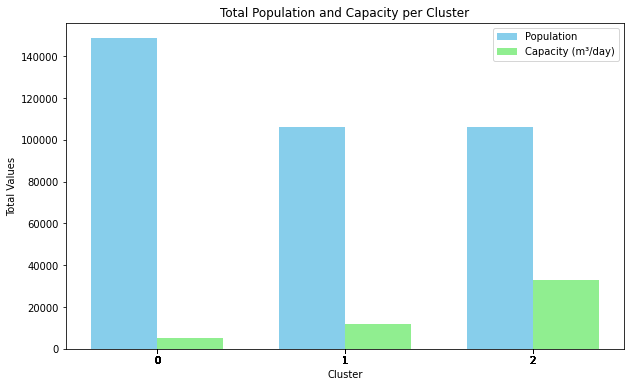

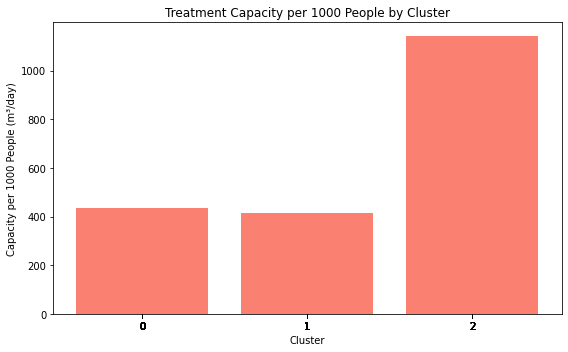

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df = wwtp_enriched
df['capacity_per_1000'] = df['Capacity'] / (df['Population'] / 1000)

# Plot 1: Total Population vs Capacity per Cluster
fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = df['cluster']

ax1.bar(x - bar_width/2, df['Population'], width=bar_width, label='Population', color='skyblue')
ax1.bar(x + bar_width/2, df['Capacity'], width=bar_width, label='Capacity (m³/day)', color='lightgreen')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Values')
ax1.set_title('Total Population and Capacity per Cluster')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels(df['cluster'])

# Plot 2: Capacity per 1000 People
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(df['cluster'], df['capacity_per_1000'], color='salmon')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Capacity per 1000 People (m³/day)')
ax2.set_title('Treatment Capacity per 1000 People by Cluster')
ax2.set_xticks(df['cluster'])

plt.tight_layout()
plt.show()


In [32]:
# Summary statistics by treatment type
df.groupby('treatment_type')['Capacity'].agg(['count', 'mean', 'median', 'min', 'max', 'std']).sort_values(by='mean', ascending=False)


,count,mean,median,min,max,std
treatment_type,,,,,,
not treated,59,6712.618773,1.0,0.7923,33000.0,13396.798541
tertiary,36,4263.666667,790.0,1.0000,12000.0,5557.621506
secondary,73,1215.397260,550.0,1.0000,5400.0,1897.000986
pond,56,279.357143,1.0,1.0000,1300.0,537.837097
primary,73,139.000000,1.0,1.0000,800.0,295.729888


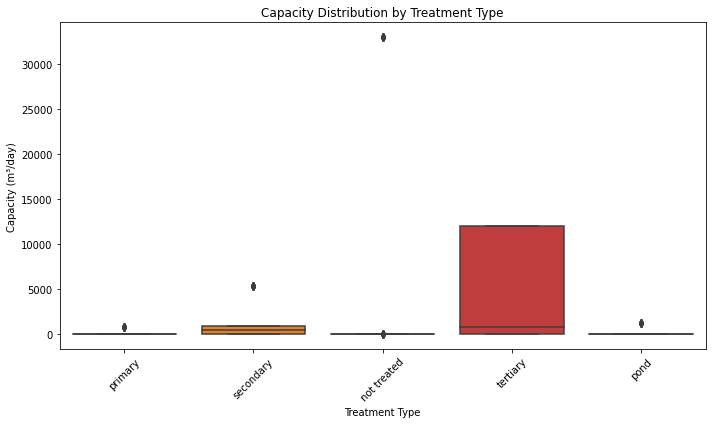

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='treatment_type', y='Capacity')
plt.xticks(rotation=45)
plt.title('Capacity Distribution by Treatment Type')
plt.ylabel('Capacity (m³/day)')
plt.xlabel('Treatment Type')
plt.tight_layout()
plt.show()


Tertiary treatment systems often show higher mean and max capacities, suggesting they are deployed in urban/high-demand settings.

Pond systems may be the most common and have lower average capacities, likely serving rural or decentralized areas.

"Not treated" entries usually show very high or very low values, potentially reflecting non-functional or industrial setups.

A high standard deviation in a treatment type (e.g., "tertiary") may suggest a wide range of plant sizes and flexibility.